In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(7,5)
# Add the application folder to the path
import sys
sys.path.insert(0,'../Peergrade/peergrade/')
import time
import math
from application.model import data_model
from matplotlib.backends.backend_pdf import PdfPages
from collections import defaultdict
import numpy as np
from bson.objectid import ObjectId
from matplotlib import pyplot as plt
from scipy.stats.stats import pearsonr
from scipy.stats import norm

SERVER_NAME: localhost:5000


In [2]:
fig_store = "../MasterThesis/Thesis/figures/Analysis/"

In [3]:
class Grader_(object):
    def __init__(self, id):
        self.id = id
        self.handins = list()
        
    def add_handin(self, handin):
        self.handins.append(handin)
                
class Question_(object):
    def __init__(self,id):
        self.id = id
                
class Answers_(object):
    def __init__(self,handin,question):
        self.handin = handin
        self.question = question
        self.answers = dict()
    
class Handin_(object):
    def __init__(self,id,owner):
        self.id = id
        self.owner = owner
        self.gradeings = dict()
        self.graders = list()
        self.catched_score = dict()
            
    def add_grader(self,grader):
        self.graders.append(grader)
        
    def add_answer(self,grader,question,value):
        if str(question.id) not in self.gradeings:
            self.gradeings[str(question.id)] = Answers_(self,question)
        self.gradeings[str(question.id)].answers[str(grader.id)] = value
        
    def get_graders_answers(self):
        graders_answers = defaultdict(list)
        for q, answer in self.gradeings.iteritems():
            for g, answer in answer.answers.iteritems():
                graders_answers[str(g)].append((str(q),answer))
            
        return graders_answers
        
    def get_grader_answers(self,grader):
        grader_answers = list()
        for key, values in self.graders.iteritems():
            grader_answers.append((key,values[grader]))
        return grader_answers
    
    def get_handin_score(self,g):
        if g not in self.catched_score:
            grader_g = list()
            for answers in self.gradeings.itervalues():
                if g not in  answers.answers:
                    return None
                grader_g.append(answers.answers[g])
            self.catched_score[g] = np.mean(grader_g)
        
        return self.catched_score[g]


class Assignment_(object):
    
    def __init__(self, handins_input, graders_input, questions_input, n_gradings):
        self.graders = dict()
        self.handins = dict()
        self.questions = dict()
        self.n_gradings = n_gradings
        for handin in handins_input:
            self.handins[str(handin.id)] = handin
        for grader in graders_input:
            self.graders[str(grader.id)] = grader
        for question in questions_input:
            self.questions[str(question.id)] = question

    def add_handin(self, handin):
        self.handing[str(handin.id)] = handin
        
    def add_grader(self, grader):
        self.graders[str(grader.id)] = grader
    
    def set_questions(self, questions):
        self.questions = list(questions)

In [4]:
def user_name(user_id):
    user = data_model.User.objects.get(id=user_id)
    return user.name

def user_id(user_name):
    for user in data_model.User.objects(name=user_name):
        return user.id

def question_text(q_id):
    user = data_model.Question.objects.get(id=ObjectId(q_id))
    return user.text

def question_max_value(question):
    if question.question_type == "boolean":
        return 1
    elif question.question_type == "numerical":
        if question.numericalAnswers:
            return max(map(int,question.numericalAnswers.keys()))
        else:
            return 1

def answer_value(answer):
    if answer.numerical_answer != None:
        return answer.numerical_answer / float(question_max_value(answer.question))
    if answer.boolean_answer != None:
        return answer.boolean_answer / float(question_max_value(answer.question))

def answeres_handin(report_grade):
    '''Returns a list of tuples containing the answer and the value of the question'''
    answers = data_model.Answer.objects(report_grade=report_grade)
    result = list()
    for answer in answers:
        if answer.numerical_answer != None or answer.boolean_answer != None:
            result.append((answer,answer_value(answer)))
    return result

In [5]:
def fetch_assignment_data(ass_obj):
    '''
    Takes an course and assignment data model object and transforms it into populated Assignment object
    Only student or all?
    '''

    print ass_obj.id
    
    ## Make dictionary to hold all the graders who have graded a handin
    graders = dict()
    
    ## Find all relevant question for the assignemnt
    questions = dict()
    for sec in ass_obj.sections:
        for question in sec.questions:
            if question.question_type != 'text':
                questions[str(question.id)] = Question_(str(question.id))
    
    ## Find all handins
    handins = dict()
    for handin_ in data_model.Handin.objects(assignment=ass_obj):
        handins[str(handin_.id)] = Handin_(str(handin_.id),str(handin_.submitter.id))    
        
    ## Find all handins graders have graded and vice versa
    n_gradings = 0
    for handin_ in data_model.Handin.objects(assignment=ass_obj):
        for grade in data_model.ReportGrade.objects(handin=handin_,state='ANSWERED'):
            
            n_gradings = n_gradings + 1
            
            # Needed if TA or Professor have graded reports as they are not initialy part of it
            if str(grade.giver.id) not in graders:
                graders[str(grade.giver.id)] = Grader_(str(grade.giver.id))
                
            handins[str(handin_.id)].add_grader(graders[str(grade.giver.id)])
            
            ## Find all answers to each question
            for answer, answer_value in answeres_handin(grade):
                if str(answer.question.id) in questions:
                    handins[str(handin_.id)].add_answer(grade.giver,answer.question,answer_value)
            
    ## update reference in graders
    for handin in handins.itervalues():
        for grader in handin.graders:
            grader.add_handin(handin)

    return Assignment_(handins.itervalues(),graders.itervalues(),questions.itervalues(),n_gradings)

In [6]:
def gibbs_model(data, samples, burn_in=0):
    
    # Counts
    N_H = len(data.handins) # Number of handins
    N_G = len(data.graders) # Number of graders
    N_Q = len(data.questions) # Number of graders
    N_g = data.n_gradings   # Number of gradings
    N_eval = N_g*N_G   # Number of evaluations in total
    
    # Hyperparameters
    ga_h = 0.5
    la_h = 1.0
    al_h = 10.0
    be_h = 0.1

    ga_g = 0.0
    la_g = 1.0
    al_g = 50.0
    be_g = 0.1
    
    al_n = 10.0
    be_n = 1.0
    
    # Prior parameters
    u_h = dict()
    t_h = dict()
    T = defaultdict(dict)
    B = defaultdict(dict)
    u_g = dict()
    t_g = dict()

    # Draw from priors
    n_v = np.random.gamma(al_n,1.0/be_n)
    for h in data.handins.iterkeys():
        t_h[h] = np.random.gamma(al_h,1.0/be_h)
        u_h[h] = np.random.normal(ga_h,np.sqrt(1.0/(la_h * t_h[h])))
        for q in data.questions.iterkeys():        
            T[h][q] = np.random.normal(u_h[h],np.sqrt(1.0/t_h[h]))
    for g in data.graders.iterkeys():
        t_g[g] = np.random.gamma(al_g,1.0/be_g)
        u_g[g] = np.random.normal(ga_g,np.sqrt(1.0/(la_g * t_g[g])))
        for q in data.questions.iterkeys():
            B[str(g)][str(q)] = np.random.normal(u_g[g],np.sqrt(1.0/t_g[g]))
            
    # Gibbs sampling #
    
    # Tracers initialising
    acc_n_v = list()
    acc_u_h = defaultdict(list)
    acc_t_h = defaultdict(list)
    acc_u_g = defaultdict(list)
    acc_t_g = defaultdict(list)
    acc_T = defaultdict(lambda: defaultdict(list))
    acc_B = defaultdict(lambda: defaultdict(list))

    tw = time.time()
    for r in range(burn_in + samples):
        print "\r%i" % (r+1) + " out of %i" % (burn_in + samples),
        # Sample T
        for h, handin in data.handins.iteritems():
            for q, answers in handin.gradeings.iteritems():
                n_gradings = len(answers.answers)
                sum_ = 0.0
                for g, val in answers.answers.iteritems():
                    sum_ = sum_ + val - B[str(g)][str(q)]
                v = n_v*n_gradings+t_h[h]
                T[h][q] = np.random.normal((u_h[h]*t_h[h]+n_v*sum_)/v,np.sqrt(1.0/v))
            
        # Sample B
        for g, grader in data.graders.iteritems():
            for q in data.questions.iterkeys():
                n_gradings = len(grader.handins)
                sum_ = 0.0
                for h in grader.handins:
                    if g in h.gradeings[q].answers:
                        sum_ = sum_ + h.gradeings[q].answers[g] - T[h.id][q]
                v = n_v * n_gradings + t_g[g]
                B[g][q] = np.random.normal((u_g[g]*t_g[g]+n_v*sum_)/v,np.sqrt(1.0/v))
        
        # Sample e
        sum_ = 0.0
        n_eval = 0
        for h, handin in data.handins.iteritems():
            for q, answers in handin.gradeings.iteritems():
                for g, answer_val in answers.answers.iteritems():
                    n_eval = n_eval + 1
                    sum_ = sum_ + np.square(answer_val - (T[h][q]+B[g][q]))
        n_v = np.random.gamma(al_n+0.5*n_eval,1.0 / (be_n+0.5*sum_))

        # Sample u_q and t_q
        for h in data.handins.iterkeys():
            la_ = (la_h+N_Q)
            sum_q = np.sum(T[h].values())
            mean_q = sum_q / N_Q
            sum_minus = 0.0
            for q in data.questions.iterkeys():
                sum_minus = sum_minus + np.square(T[h][q]-mean_q)
            al_ = al_h+0.5*N_Q
            be_ = be_h+0.5*(N_Q*sum_minus+(N_Q*la_h*np.square(mean_q-ga_h))/la_)
            t_h[h] = np.random.gamma(al_,1.0 / be_)
            u_h[h] = np.random.normal((la_h*ga_h+sum_q)/la_,np.sqrt(1.0/(la_*t_h[h])))

        # Sample u_g and t_g
        for g in data.graders.iterkeys():
            la_ = (la_g+N_Q)
            sum_q = np.sum(B[g].values())
            mean_q = sum_q / N_Q
            sum_minus = 0.0
            for q in data.questions.iterkeys():
                sum_minus = sum_minus + np.square(B[g][q]-mean_q)
            al_ = al_g+0.5*N_Q
            be_ = be_g+0.5*(N_Q*sum_minus+(N_Q*la_g*np.square(mean_q-ga_g))/la_)
            t_g[g] = np.random.gamma(al_,1.0 / be_)
            u_g[g] = np.random.normal((la_g*ga_g+sum_q)/la_,np.sqrt(1.0/(la_*t_g[g])))
                        
        # Collect tracings
        if r > burn_in:
            acc_n_v.append(n_v)
            for h in data.handins.iterkeys():
                acc_u_h[h].append(u_h[h])
                acc_t_h[h].append(t_h[h])
                for q in data.questions.iterkeys():
                    acc_T[h][q].append(T[h][q])
            for g in data.graders.iterkeys():
                acc_u_g[g].append(u_g[g])
                acc_t_g[g].append(t_g[g])
                for q in data.questions.iterkeys():
                    acc_B[g][q].append(B[g][q])
                    
    print
    print "Wall time: %f" % (time.time() - tw)
    
    traces = {'n_v' : acc_n_v,
              'u_h' : acc_u_h,
              't_h' : acc_t_h,
              'u_g' : acc_u_g,
              't_g' : acc_t_g,
              'T' : acc_T,
              'B' : acc_B}

    return traces

In [7]:
def norm_log_pdf(x,u,t):
    return -0.5*t*(x-u)**2+np.log(t)-np.log(np.sqrt(2.0*math.pi))

def gamma_log_pdf(x,a,b):
    return a*np.log(b)-np.log(math.gamma(a))+(a-1.0)*np.log(x)-b*x

def norm_gamma_log_pdf(u,t,ga,la,a,b):
    return a*np.log(b)+np.log(np.sqrt(la))-np.log(math.gamma(a))-np.log(np.sqrt(2.0*math.pi))+(a-1)*np.log(t)-np.log(b*t)-0.5*t*la*(u-ga)**2

In [8]:
def MH_model(data,samples,burn_in=0):

    # Counts
    N_H = len(data.handins) # Number of handins
    N_G = len(data.graders) # Number of graders
    N_g = data.n_gradings   # Number of gradings
    N_eval = N_g*N_G   # Number of evaluations in total
    
    # Hyperparameters
    ga_h = 0.5
    la_h = 1.0
    al_h = 10.0
    be_h = 0.1

    ga_g = 0.0
    la_g = 1.0
    al_g = 50.0
    be_g = 0.1
    
    al_e = 10.0
    be_e = 1.0
    t_h = 500.0
    t_g = 100.0
    
    # Prior parameters
    u_h = dict()
    t_h = dict()
    u_g = dict()
    t_g = dict()
    
    log_h = dict()
    log_g = dict()

    def prop_u_t_h(handin,u_h,t_h):
        sum_ = 0.0
        for g in handin.graders:
            val = handin.get_handin_score(g.id)
            if val <> None:
                sum_ = sum_ + norm_log_pdf(val,u_g[g.id]+u_h,t_g[g.id]+t_h)
        return sum_ + norm_gamma_log_pdf(u_h,t_h,ga_h,la_h,al_h,be_h)
    
    def prop_u_t_g(grader,g,u_g,t_g):
        sum_ = 0.0
        for h in grader.handins:
            val = h.get_handin_score(g)
            if val <> None:
                sum_ = sum_ + norm_log_pdf(val,u_g+u_h[h.id],t_g+t_h[h.id])
        return sum_ + norm_gamma_log_pdf(u_g,t_g,ga_g,la_g,al_g,be_g)

    
    # Draw from priors
    for h in data.handins.iterkeys():
        t_h[h] = np.random.gamma(al_h,1/be_h)
        u_h[h] = np.random.normal(ga_h,np.sqrt(1/(la_g * t_h[h])))
    for g in data.graders.iterkeys():
        t_g[g] = np.random.gamma(al_g,1/be_g)
        u_g[g] = np.random.normal(ga_g,np.sqrt(1/(la_g * t_g[g]))) 
    # pre calcuate the liklyhood
    for h, handin in data.handins.iteritems():
        log_h[h] = prop_u_t_h(handin,u_h[h],t_h[h])
    for g, grader in data.graders.iteritems():
        log_g[g] = prop_u_t_g(grader,g,u_g[g],t_g[g])
            
    # Tracers initialising
    trace_u_h = defaultdict(list)
    trace_t_h = defaultdict(list)
    trace_u_g = defaultdict(list)
    trace_t_g = defaultdict(list)
    
    tw = time.time()
    for r in range(burn_in + samples):
        print "\r%i" % (r+1) + " out of %i" % (burn_in + samples),
        
        # Sample u_h and t_h
        for h, handin in data.handins.iteritems():
            # Propose new candidates
            u_h_c = np.random.normal(u_h[h],0.1)
            t_h_c = np.random.normal(t_h[h],0.1)
            #draw from gamma
            p_ = prop_u_t_h(handin,u_h_c,t_h_c)
            alpha = min(1,p_-log_h[h])
            if np.log(np.random.random()) <= alpha:
                u_h[h] = u_h_c
                t_h[h] = t_h_c
                log_h[h] = p_
                    
        # Sample u_g and t_g
        for g, grader in data.graders.iteritems():
            # Propose new candidates
            u_g_c = np.random.normal(u_g[g],0.1)
            t_g_c = np.random.normal(t_g[g],0.1)
            #draw from gamma
            p_ = prop_u_t_g(grader,g,u_g_c,t_g_c)
            alpha = min(1,p_-log_g[g])
            if np.log(np.random.random()) <= alpha:
                u_g[g] = u_g_c
                t_g[g] = t_g_c    
                log_g[g] = p_

        # Collect tracings
        if r > burn_in:
            for h in data.handins.iterkeys():
                trace_u_h[h].append(u_h[h])
                trace_t_h[h].append(t_h[h])
            for g in data.graders.iterkeys():
                trace_u_g[g].append(u_g[g])
                trace_t_g[g].append(t_g[g])
                
    print
    print "Wall time: %f" % (time.time() - tw)
    
    
    traces = {'u_h' : trace_u_h,
              't_h' : trace_t_h,
              'u_g' : trace_u_g,
              't_g' : trace_t_g}

    return traces

In [9]:
def truncate(string,length):
    return (string[:length] + '..') if len(string) > length else string

In [10]:
def handin_students(h_id):
    model_handin = data_model.Handin.objects.get(id=ObjectId(h_id))
    students_ = list()
    for student in model_handin.students:
        students_.append(student.name)
    return ", ".join(students_)

In [11]:
def plot_question_bias(t,result):
    for q in t.questions.iterkeys():
        scores = list()
        for id, g in t.graders.iteritems():
            scores.append((user_name(ObjectId(id)),np.mean(result['B'][id][q]),np.std(result['B'][id][q])))

        ax = plt.subplot(111)

        scores.sort(key=lambda x:x[1])
        model_1 = map(lambda x : float(x[1]),scores)
        model_e = map(lambda x : float(x[2]),scores)

        label = map(lambda x : x[0],scores)
        y = xrange(0,len(scores))
        plt.errorbar(model_1,y,xerr=model_e,fmt='or',label="Gibbs sampling",alpha=0.65)

        box = ax.get_position()
        ax.set_position([box.x0, box.y0,
                         box.width+0.45, box.height*5])
        plt.yticks(xrange(0,len(scores)),label)
        plt.legend(loc=4)
        plt.title("Grader bias: " + question_text(q))
        plt.xlim(-0.5,0.5)
        plt.vlines(0, 0, len(scores), color="k", linestyles="--", lw=1)
        plt.ylabel("Grader")
        plt.xlabel("Bias")
        plt.show()

In [12]:
def plot_question_score(t,result):
    for q in t.questions.iterkeys():
        scores = list()
        for h, handin in t.handins.iteritems():
            scores.append((handin_students(h),np.mean(result['T'][h][q]),np.std(result['T'][h][q]),handin.answers[q].values()))

        ax = plt.subplot(111)

        scores.sort(key=lambda x:x[1])
        model_1 = map(lambda x : float(x[1]),scores)
        model_e = map(lambda x : float(x[2]),scores)
        mean = map(lambda x : x[3],scores)

        label = map(lambda x : x[0],scores)
        y = xrange(0,len(scores))
        plt.errorbar(model_1,y,xerr=model_e,fmt='or',label="Gibbs sampling",alpha=0.7)
        plt.boxplot(mean, positions=y, vert=False)

        box = ax.get_position()
        ax.set_position([box.x0, box.y0,
                         box.width+0.45, box.height*4])
        plt.yticks(xrange(0,len(scores)),label)
        plt.legend(loc=4)
        plt.title(question_text(q))
        plt.xlim(-0.5,1.5)
        plt.ylabel("Handin")
        plt.xlabel("Score")
        plt.show()

In [13]:
def plot_bias(t,result,nth=1):
    scores = list()
    for id, g in t.graders.iteritems():
        text = truncate(user_name(ObjectId(id)),45)
        text = text + ": %i" % len(t.graders[id].handins)
        q_bias = list()
        for q in t.questions.iterkeys():
            q_bias.append(result['B'][id][q])
        scores.append((text,np.mean(result['u_g'][id]),np.sqrt(1.0 / np.mean(result['t_g'][id])),q_bias))
    scores = scores[::nth]
    ax = plt.subplot(111)

    scores.sort(key=lambda x:x[1])
    model_1 = map(lambda x : float(x[1]),scores)
    xerr = map(lambda x : float(x[2]),scores)
    bias_q = map(lambda x : x[3],scores)
    
    label = map(lambda x : x[0],scores)
    y = xrange(0,len(scores))
    plt.errorbar(model_1,y,xerr=xerr,fmt='o',color="#467821",label="Latent Bias")
    plt.boxplot(bias_q, positions=y, vert=False)

    plt.yticks(xrange(0,len(scores)),label)
    leg = plt.legend(numpoints=1,loc=4)
    leg.get_frame().set_alpha(0.4)
    plt.title("Bias of the graders")
    plt.vlines(0, 0, len(scores), color="k", linestyles="--", lw=1)
    plt.ylabel("Grader : [Graded handins]")
    plt.xlabel("Bias")
    plt.show()

In [14]:
def plot_handins(t,result,nth=1):
    scores = list()
    for id, handin in t.handins.iteritems():
        gradings = list()
        for x  in handin.get_graders_answers().values():
            inter = list()
            for (q,val) in x:
                inter.append(val)
            gradings.append(np.mean(inter))
        l = truncate(handin_students(id),45)
        scores.append((l,np.mean(result['u_h'][id]),np.sqrt(1.0 / np.mean(result['t_h'][id])),gradings))

    ax = plt.subplot(111)

    scores.sort(key=lambda x:x[1])
    scores = scores[::nth]
    model_1 = map(lambda x : float(x[1]),scores)
    xerr = map(lambda x : x[2],scores)
    mean = map(lambda x : x[3],scores)
    
    label = map(lambda x : x[0],scores)
    y = xrange(0,len(scores))
#    plt.plot(model_1,y,'o',color="#348ABD",label="Latent Handin Score",alpha=0.65)
    plt.errorbar(model_1,y,xerr=xerr,fmt='o',color="#A60628",label="Latent Handin Score",alpha=0.65)
#    plt.boxplot(mean, positions=y, vert=False)
    
    plt.yticks(xrange(0,len(scores)),label)
    leg = plt.legend(numpoints=1,loc=4)
    leg.get_frame().set_alpha(0.4)
    plt.title("True score of handins")
    plt.vlines(0, 0, len(scores), color="k", linestyles="--", lw=1)
    plt.vlines(1, 0, len(scores), color="k", linestyles="--", lw=1)
    plt.ylabel("Question")
    plt.xlabel("Score")
#    plt.xlim(0,1)
    plt.margins(0.02)
    plt.tight_layout()
    plt.show()

In [15]:
def plot_collected_handin_score(t,result,nth=1):
    scores = list()

    for h, handin in t.handins.iteritems():
        g_c = list()
        h_list = list()
        for q in t.questions.iterkeys():
            l = list()
            for answers in handin.gradeings[q].answers.itervalues():
                l.append(answers)
            h_list.append(np.mean(result['T'][h][q]))
            g_c.append(np.mean(l))
        obs_v = g_c
        model_v = h_list
        scores.append((h,model_v,obs_v,np.mean(result['u_h'][h])))
    
    ax = plt.subplot(111)

    scores.sort(key=lambda x:x[3])
    scores = scores[::nth]
    
    model = map(lambda x : x[1],scores)
    obs = map(lambda x : x[2],scores)
    obs_m = map(lambda x : np.mean(x[2]),scores)
    found = map(lambda x : x[3],scores)

    y = range(0,len(scores)*2,2)
    for i in range(len(scores)):
        y_ = y[i]
        
        plt.hlines(y_-1, -0.2, 1.2, color="k", linestyles="-", lw=1,alpha=0.5)
        
        if i == 0:
            plt.plot(obs_m[i],y_+0.6,'o',color='#348ABD',label="Observed Handin Score")
            plt.plot(obs[i],[y_+0.2]*len(obs[i]),'|',color="#348ABD", label="Observed Questions Scores")
            plt.plot(found[i],y_-0.2,'o',color="#A60628",label="Found Handin Score")
            plt.plot(model[i],[y_-0.6]*len(model[i]),'|',color="#A60628", label="Found Question Scores")
        plt.plot(obs_m[i],y_+0.6,'o',color="#348ABD")
        plt.plot(obs[i],[y_+0.2]*len(obs[i]),'|',color="#348ABD")
        plt.plot(found[i],y_-0.2,'o',color="#A60628")
        plt.plot(model[i],[y_-0.6]*len(model[i]),'|',color="#A60628")
        

    label = map(lambda x : truncate(handin_students(x[0]),45),scores)
    
    plt.yticks(y,label)
    leg = plt.legend(numpoints=1,loc=2)
    leg.get_frame().set_alpha(0.4)
    plt.xlim(-0.2,1.2)
    plt.autoscale(tight=True)
    plt.title("Score")
    plt.ylabel("Owners of the handins")
    plt.xlabel("Model score vs Question score vs Observed Question score")
    plt.margins(0.05)
    plt.tight_layout()
    plt.show()

In [16]:
a1 = data_model.Assignment.objects.get(title="Aflevering 1: Sjov med tabeller")

a1_data = fetch_assignment_data(a1)

56ab3b44002566000f6f34e8


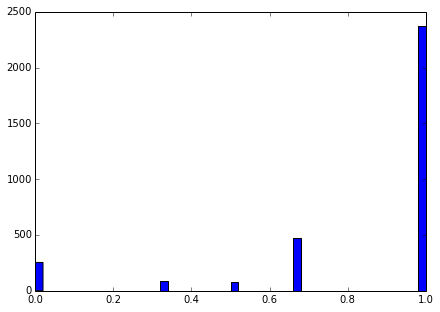

In [362]:
figsize(7,5)
q_scores = list()
for handin in a1_data.handins.itervalues():
    for answer in handin.gradeings.itervalues():
        q_scores.extend(answer.answers.values())
plt.hist(q_scores,bins=50)
plt.show()

In [17]:
a1_result_MH = MH_model(a1_data,5000,burn_in=1000)

6000 out of 6000
Wall time: 186.834089


In [37]:
a1_result = a1_result_MH

In [54]:
a1_result = gibbs_model(a1_data,5000,burn_in=1000)

6000 out of 6000
Wall time: 376.096545


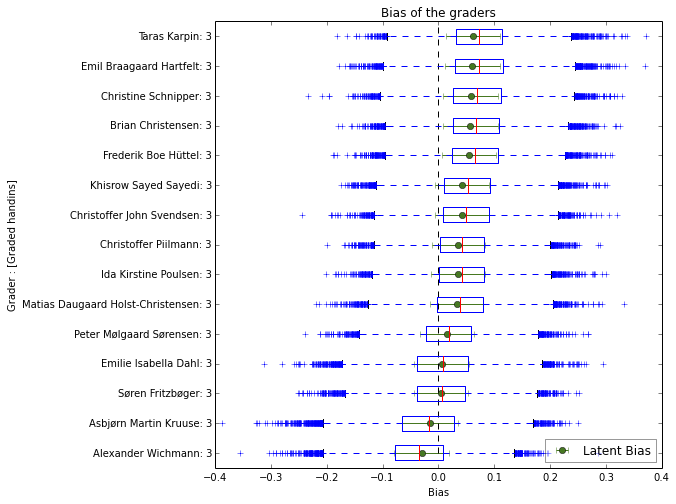

In [141]:
with PdfPages(fig_store + "Algo_Ass1_Bias.pdf") as pdf:
    fig = plt.figure(figsize(8,8))
    plot_bias(a1_data,a1_result,nth=15)
    pdf.savefig(fig)


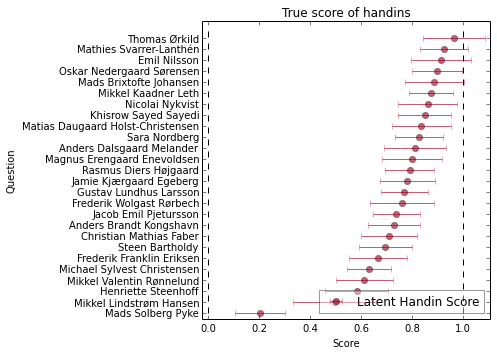

In [384]:
#with PdfPages(fig_store + "Algo_Ass1_Handins.pdf") as pdf:
#fig = plt.figure(figsize(8,8))
plot_handins(a1_data,a1_result_MH,nth=10)
#    pdf.savefig(fig)

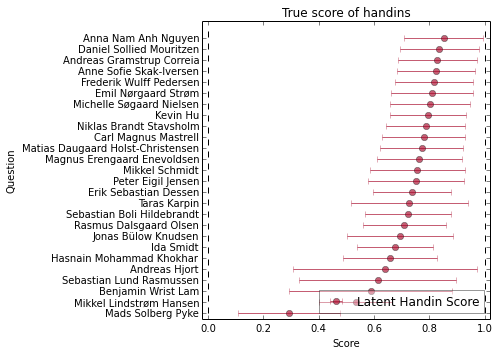

In [385]:
#with PdfPages(fig_store + "Algo_Ass1_Handins.pdf") as pdf:
#fig = plt.figure(figsize(8,8))
plot_handins(a1_data,a1_result,nth=10)
#    pdf.savefig(fig)

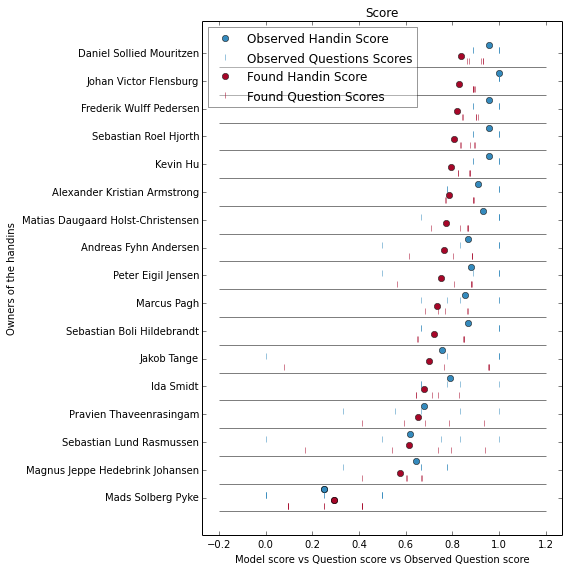

In [143]:
with PdfPages(fig_store + "Algo_Ass1_Handins_Questions.pdf") as pdf:
    fig = plt.figure(figsize(8,8))
    plot_collected_handin_score(a1_data,a1_result,nth=15)
    pdf.savefig(fig)

In [18]:
a2 = data_model.Assignment.objects.get(title="Aflevering 2: Manglende tal")

a2_data = fetch_assignment_data(a2)

56bc9547ab0a12000f253e5b


In [26]:
a2_result = MH_model(a2_data,5000,burn_in=1000)

6000 out of 6000
Wall time: 147.160628


In [19]:
a3 = data_model.Assignment.objects.get(title="Aflevering 3: Kompleksitet")

a3_data = fetch_assignment_data(a3)

56c5d7abab1c890015689251


In [27]:
a3_result = MH_model(a3_data,5000,burn_in=1000)

6000 out of 6000
Wall time: 160.678510


In [20]:
a4 = data_model.Assignment.objects.get(title="Aflevering 4: Implementation af dobbelt-hægtede lister")

a4_data = fetch_assignment_data(a4)

56d05d7d6e0834000f91fa10


In [62]:
a4_result = MH_model(a4_data,5000,burn_in=1000)

6000 out of 6000
Wall time: 136.937064


In [21]:
a5 = data_model.Assignment.objects.get(title="Aflevering 5: Hobe og tabeller")

a5_data = fetch_assignment_data(a5)

56d987cead9a03001bb3b4eb


In [29]:
a5_result = MH_model(a5_data,5000,burn_in=1000)

6000 out of 6000
Wall time: 133.825091


In [22]:
a6 = data_model.Assignment.objects.get(title="Aflevering 6: Dybdeførst søgning")

a6_data = fetch_assignment_data(a6)

56e2cb7b3a25980015a2a922


In [30]:
a6_result = MH_model(a6_data,5000,burn_in=1000)

6000 out of 6000
Wall time: 35.353246


In [23]:
a7 = data_model.Assignment.objects.get(title="Aflevering 7: Sociale Netværk")

a7_data = fetch_assignment_data(a7)

56eff76c326bb3000f4f5e2b


In [31]:
a7_result = MH_model(a7_data,5000,burn_in=1000)

6000 out of 6000
Wall time: 61.469646


In [24]:
a8 = data_model.Assignment.objects.get(title="Aflevering 8: Plantegning")

a8_data = fetch_assignment_data(a8)

56eff6a0326bb3000f4f5e2a


In [32]:
a8_result = MH_model(a8_data,5000,burn_in=1000)

6000 out of 6000
Wall time: 58.627210


In [25]:
a9 = data_model.Assignment.objects.get(title="Aflevering 9: Kruskals algoritme")

a9_data = fetch_assignment_data(a9)

56eff7f4326bb3000f4f5e2c


In [33]:
a9_result = MH_model(a9_data,5000,burn_in=1000)

6000 out of 6000
Wall time: 23.579776


In [104]:
all_data = [(a1_data,a1_result),(a2_data,a2_result),(a3_data,a3_result),(a4_data,a4_result),
            (a5_data,a5_result),(a6_data,a6_result),(a7_data,a7_result),(a8_data,a8_result),(a9_data,a9_result)]

In [391]:
for (ass_data, ass_result) in all_data:
    print len(ass_data.graders),  len(ass_data.handins), len(ass_data.questions), 
    print np.mean([len(x.graders) for x in ass_data.handins.values()]),
    print np.mean([len(x.handins) for x in ass_data.graders.values()])    

221 253 5 2.60869565217 2.98642533937
196 212 8 2.75 2.97448979592
222 235 7 2.8085106383 2.97297297297
166 182 3 2.72527472527 2.98795180723
179 202 4 2.62871287129 2.96648044693
48 56 2 2.57142857143 3.0
80 95 5 2.50526315789 2.975
73 88 5 2.45454545455 2.95890410959
28 32 2 2.59375 2.96428571429


In [135]:
def plot_all_grader_bias(data_result,nth=1):
    
    grader_bias = defaultdict(list)
    grader_n_h = defaultdict(list)
    grader_ass = defaultdict(list)
    
    for i, (data,result) in enumerate(data_result):

        for id, g in data.graders.iteritems():
            n_h = len(data.graders[id].handins)
            grader_n_h[id].append(n_h)
            grader_bias[id].append((np.mean(result['u_g'][id])))
            grader_ass[id].append(i+1)

    scores = list()
    for name, values in grader_bias.iteritems():
        l = user_name(ObjectId(name)) + ": %i, %i" % (len(grader_n_h[name]),sum(grader_n_h[name]))
        scores.append((l,values,grader_ass[name]))
    scores.sort(key=lambda x: np.mean(x[1]))
    scores = scores[6::nth]
    
    ax = plt.subplot(111)
    
    plotted = dict()
    p_style = {1:'v',2:'.',3:'<',4:'d',5:'8',6:'s',7:'x',8:'*',9:'+'}
    
    model = map(lambda x : x[1],scores)
    model_m = map(lambda x : np.mean(x[1]),scores)
    ass = map(lambda x : x[2],scores)
    label = map(lambda x : x[0],scores)
    y = xrange(0,len(scores))
    for i, m in enumerate(model):
        for j, n in enumerate(m):
            a = ass[i][j] 
            if a not in plotted:
                plt.plot(m[j],y[i],p_style[a],color="#467821",label="Assignemnt "+str(a),alpha=0.65)
                plotted[a] = True
            else:
                plt.plot(m[j],y[i],p_style[a],color="#467821",alpha=0.65)
#    plt.boxplot(model_1,positions=y, vert=False)
    plt.plot(model_m,y,'o',color="#A60628",label="Average Bias",alpha=0.65)

    plt.yticks(xrange(0,len(scores)),label)
    plt.legend(loc=4)
    plt.title("Bias over Assignments")
    plt.vlines(0, 0, len(scores), color="k", linestyles="--", lw=1)
    plt.ylabel("Grader: [Graded assignments], [Graded handins]")
    plt.xlabel("Bias")
    plt.margins(0.01)
    plt.show()

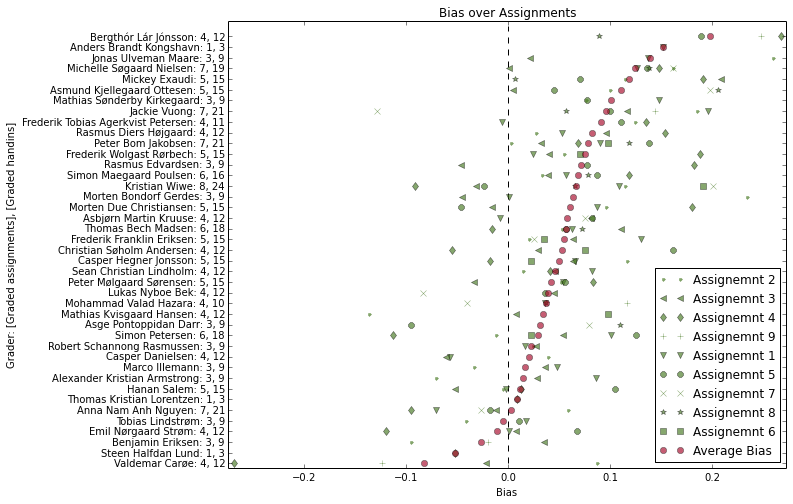

In [136]:
with PdfPages(fig_store + "Algo_Ass_Bias.pdf") as pdf:
    fig = plt.figure(figsize(10,8))
    plot_all_grader_bias(all_data,nth=7)
    pdf.savefig(fig,bbox_inches='tight')

Valdemar Carøe

In [126]:
def plot_question_hist((ass_data,ass_result),name_,plot = True,question = None, question_contains = None):
    '''
    Plots the questions value and the graders values for each handin the person have graded
    '''
    u_id = user_id(name_)

    bar_width = 0.2
    
    tot_neg = 0
    tot_pos = 0
    tot_net = 0
    tot_n = 0
    
    if question:
        print "Question: %s" % question_text(question)
    
    # Find the handins that the person have graded    
    for handin in ass_data.graders[str(u_id)].handins:
        # find the values of each question in each hadnin
        print "Handin: %s" % handin.id
        
        neutral = 0
        positive = 0
        negative = 0
        
        n_q = 0
        
        for q in ass_data.questions.iterkeys():
            if question and q <> question:
                continue
            if question_contains:
                if question_contains not in question_text(q):
                    continue
                else:
                    print question_text(q)
                    
            tot_n = tot_n + 1 
            n_q = n_q + 1 
            
            q_data_model = data_model.Question.objects.get(id=ObjectId(q))
            q_max = question_max_value(q_data_model)            
            
            q_values = map(lambda x : int(x*q_max),handin.gradeings[q].answers.values())
            g_q_val = int(handin.gradeings[q].answers[str(u_id)]*q_max)

            val = [0]*(q_max+1)
            for q_val in q_values:
                val[q_val] = val[q_val] + 1
                
            if np.median(q_values) - 0.5 > g_q_val:
                tot_neg = tot_neg + 1
                negative = negative + 1
                if plot:
                    print "[Negative]",
            elif np.median(q_values) + 0.5 < g_q_val:
                tot_pos = tot_pos + 1
                positive = positive + 1
                if plot:
                    print "[Positive]",
            else:
                tot_net = tot_net + 1
                neutral = neutral + 1
                if plot:
                    print "[Neutral]",

                    
            if plot:
                print "Median: %f" % np.median(q_values),
                print "Given score: %i" % g_q_val

                ax = plt.subplot(111) 

                bar = plt.bar(range(0,q_max+1),val,width=bar_width,alpha = 0.65, linewidth=0,align='center',color='gray')
                bar[g_q_val].set_color('r')
                plt.xticks(range(0,q_max+1),range(0,q_max+1))
                box = ax.get_position()
                ax.set_position([box.x0, box.y0,
                                 box.width*2, box.height*1])
                plt.legend(loc=4)
                plt.ylim(0,max(val)+1)
                plt.title(question_text(q))
                plt.xlabel("value")
                plt.show()

        result = [("Positive",positive),("Neutral",neutral),("Negative",negative)]
        for (l,v) in result:
            print str(v) + " " + l + " (%.1f%%)" % ((float(v)/float(n_q))*100.0),
        if not question or not question_contains:
            print "out of %i" % n_q
        print
    
    if not question or not question_contains:
        print "Total result:"
        result = [("Positive",tot_pos),("Neutral",tot_net),("Negative",tot_neg)]
        for (l,v) in result:
            print str(v) + " " + l + " (%.1f%%)" % ((float(v)/float(tot_n))*100.0),
        print "out of %i" % tot_n
    print 

In [102]:
collected_ass_data = [(a1_data,a1_result),(a2_data,a2_result),(a3_data,a3_result),(a4_data,a4_result),
                     (a5_data,a5_result),(a6_data,a6_result),(a7_data,a7_result),(a8_data,a8_result),
                     (a9_data,a9_result)]

In [127]:
plot_question_hist((a4_data,a4_result),u'Valdemar Carøe',plot=False)

Handin: 56dc09894a4bed000f327ec9
0 Positive (0.0%) 0 Neutral (0.0%) 3 Negative (100.0%) out of 3

Handin: 56d813204399280015d24fc4
0 Positive (0.0%) 2 Neutral (66.7%) 1 Negative (33.3%) out of 3

Handin: 56dc30ab4a4bed000f328145
0 Positive (0.0%) 1 Neutral (33.3%) 2 Negative (66.7%) out of 3

Total result:
0 Positive (0.0%) 3 Neutral (33.3%) 6 Negative (66.7%) out of 9



In [128]:
user_id('Valdemar Carøe')

ObjectId('56979e4d700960000f17075f')

In [129]:
def get_grader_answers(handin,g):
        grader_g = list()
        for answers in handin.gradeings.itervalues():
            if g not in answers.answers:
                return None
            grader_g.append(answers.answers[g])
        return grader_g

In [134]:
for handin in a4_data.graders['56979e4d700960000f17075f'].handins:
    print handin_students(handin.id)
    values = list()
    for grader in handin.graders:
        print user_name(grader.id)
        print np.mean(get_grader_answers(handin,grader.id)), np.mean(a4_result['u_g'][grader.id])
        values.append(np.mean(get_grader_answers(handin,grader.id)))
    print "Observed mean"
    print np.mean(values)
    print "Model hand_in score"
    print np.mean(a4_result['u_h'][handin.id])
    print 

Simon Heimdal
Valdemar Carøe
0.277777777778 -0.269410069148
Emre Kayhan
0.888888888889 0.199855165327
Michael Sylvest Christensen
1.0 0.138085665687
Observed mean
0.722222222222
Model hand_in score
0.682441515357

Martin Dalby
Valdemar Carøe
0.555555555556 -0.269410069148
Simon Koimaru Skaarup
0.888888888889 -0.0269101758808
Mustafa Sidiqi
0.888888888889 0.0694722959939
Observed mean
0.777777777778
Model hand_in score
0.835457639576

Alexander Wichmann
Valdemar Carøe
0.277777777778 -0.269410069148
Shehip Ramadani
1.0 0.283021590132
Mikael Staugaard Mejling
0.777777777778 0.0748659013419
Observed mean
0.685185185185
Model hand_in score
0.642551002588



In [111]:
def find_nature((ass_data,ass_result)):
    
    tot_neg = 0
    tot_pos = 0
    tot_net = 0
    tot_n = 0
    
    for u_id, grader in ass_data.graders.iteritems():
    # Find the handins that the person have graded    
        for handin in grader.handins:
            # find the values of each question in each hadnin

            for q in ass_data.questions.iterkeys():


                q_data_model = data_model.Question.objects.get(id=ObjectId(q))
                q_max = question_max_value(q_data_model)            

                q_values = map(lambda x : int(x*q_max),handin.gradeings[q].answers.values())
                if q not in handin.gradeings or str(u_id) not in handin.gradeings[q].answers:
                    continue
                g_q_val = int(handin.gradeings[q].answers[str(u_id)]*q_max)

                tot_n = tot_n + 1 
                
                val = [0]*(q_max+1)
                for q_val in q_values:
                    val[q_val] = val[q_val] + 1

                if np.median(q_values) - 0.5 > g_q_val:
                    tot_neg = tot_neg + 1
                elif np.median(q_values) + 0.5 < g_q_val:
                    tot_pos = tot_pos + 1
                else:
                    tot_net = tot_net + 1
    
    print "Total result:"
    result = sorted([("Positive",tot_pos),("Neutral",tot_net),("Negative",tot_neg)],key=lambda x : x[1], reverse=True)
    for (l,v) in result:
        print str(v) + " " + l + " (%.1f%%)" % ((float(v)/float(tot_n))*100.0),
    print "out of %i" % tot_n

In [113]:
find_nature((a2_data,a2_result))

Total result:
3866 Neutral (82.9%) 461 Negative (9.9%) 337 Positive (7.2%) out of 4664
